In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from numpy import mean
import pandas as pd
import scipy.stats as stats 

In [3]:
import datetime as dt

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [11]:
Measurement_first_row = session.query(Measurement).first()
Measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2de19e46320>,
 'id': 1,
 'date': '2010-01-01',
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08}

In [12]:
Station_first_row=session.query(Station).first()
Station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2de19e58470>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

# Exploratory Climate Analysis

The latest date in database is 2017-08-23 00:00:00.
The date of a year before the latest date in database is 2016-08-23 00:00:00.


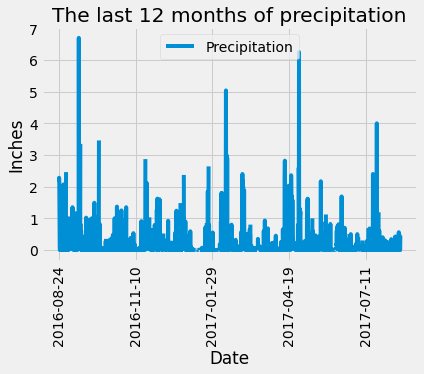

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
latest_date = dt.datetime.strptime(latest_date[0], '%Y-%m-%d') # Converting format from String to Date 
year_ago = latest_date - dt.timedelta(days=365)
print(f"The latest date in database is {latest_date}.")
print(f"The date of a year before the latest date in database is {year_ago}.")

# Perform a query to retrieve the data and precipitation scores
last_year_precipitation = session.query(Measurement.date , Measurement.prcp).\
    filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(last_year_precipitation , columns=("Date" , "Precipitation"))
prcp_df.set_index(prcp_df["Date"] , inplace=True)

# Sort the dataframe by date
prcp_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="The last 12 months of precipitation" , rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
stn_no = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"The number of available stations is {stn_no}.")

The number of available stations is 9.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station , func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

most_active_station=stations[0][0]
print(f" The most active station is {most_active_station}.")

 The most active station is USC00519281.


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_temperature = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
max_temperature = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
avg_temperature = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
print(f"The lowest temperature recorded in the most active station is {min_temperature} degrees of Farenheit.")
print(f"The highest temperature recorded in the most active station is {max_temperature} degrees of Farenheit.")
print(f"The average temperature recorded in the most active station is {round(avg_temperature,0)} degrees of Farenheit.")

The lowest temperature recorded in the most active station is 54.0 degrees of Farenheit.
The highest temperature recorded in the most active station is 85.0 degrees of Farenheit.
The average temperature recorded in the most active station is 72.0 degrees of Farenheit.


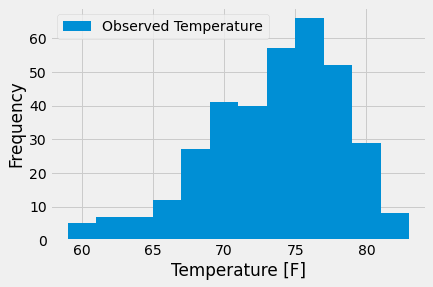

In [18]:
# Choose the station with the highest number of temperature observations.
station = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()

station_with_highest_tobs_no = station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date_for_active_session = session.query(func.max(Measurement.date)).scalar()
a_year_before_for_active_session = dt.datetime.strptime(latest_date_for_active_session,'%Y-%m-%d') - dt.timedelta(days=365)

last_12_months_tobs = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == station_with_highest_tobs_no).\
        filter(Measurement.date >= a_year_before_for_active_session).all()

temp_df=pd.DataFrame(last_12_months_tobs, columns=("Date", "Observed Temperature"))
temp_df.set_index("Date", inplace=True)
temp_df.plot(kind="hist", bins=12)
plt.xlabel("Temperature [F]")
plt.ylabel("Frequency")
plt.show()



## Bonus Challenge Assignment

### Temperature Analysis I

In [19]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.
jun_date=[]
jun_temp=[]
dec_date=[]
dec_temp=[]

for row in session.query(Measurement.date, Measurement.tobs).all():
    if dt.datetime.strptime(row[0],"%Y-%m-%d").strftime("%m") == "06":
        jun_date.append(row[0])
        jun_temp.append(row[1])
    if dt.datetime.strptime(row[0],"%Y-%m-%d").strftime("%m") == "12":
        dec_date.append(row[0])
        dec_temp.append(row[1])

jun_df=pd.DataFrame({"Date":jun_date , "Temperature":jun_temp})
jun_df.set_index("Date", inplace=True)

dec_df=pd.DataFrame({"Date":dec_date , "Temperature":dec_temp})
dec_df.set_index("Date", inplace=True)
print(f"Average temperature in June at all stations across all available years is {round(mean(jun_temp),0)} degrees of Farenheit")
print(f"Average temperature in December at all stations across all available years is {round(mean(dec_temp),0)} degrees of Farenheit")


Average temperature in June at all stations across all available years is 75.0 degrees of Farenheit
Average temperature in December at all stations across all available years is 71.0 degrees of Farenheit


In [20]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
# Will you use a paired t-test, or an unpaired t-test? Why?

# Paired t-test
stats.ttest_ind(jun_temp, dec_temp, equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

### Temperature Analysis II

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
    
# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [184]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_min_temp = calc_temps('2012-02-28', '2012-03-05')[0][0]
trip_max_temp = calc_temps('2012-02-28', '2012-03-05')[0][2]
trip_avg_temp = round(calc_temps('2012-02-28', '2012-03-05')[0][1],0)

print(f"""The following information is available for a trip from 2012-02-28 to 2012-03-05:
    Minimum temperature is {trip_min_temp} F.
    Maximum temperature is {trip_max_temp} F.
    Average temperature is {trip_avg_temp} F.""")


The following information is available for a trip from 2012-02-28 to 2012-03-05:
    Minimum temperature is 62.0 F.
    Maximum temperature is 74.0 F.
    Average temperature is 70.0 F.


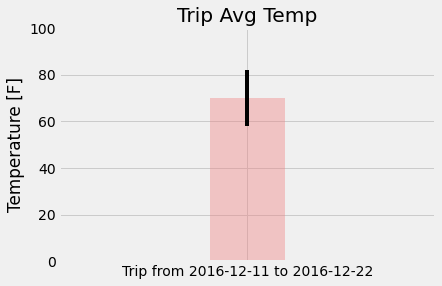

In [185]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")

# Use the average temperature for the y value
y = trip_avg_temp

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_err = trip_max_temp - trip_min_temp

x = f"Trip from {trip_start_date} to {trip_end_date}"
plt.bar(x,y, yerr=y_err, color="lightcoral", alpha=0.4)
plt.xlim(-2, 2)
plt.ylim(0, 100)
plt.ylabel("Temperature [F]")
plt.show()


### Daily Rainfall Average

In [186]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]

rainfall = session.query(*sel).group_by(Measurement.station).filter(Measurement.station == Station.station).\
    filter(Measurement.date>=trip_start_date).filter(Measurement.date<=trip_end_date).\
        order_by(func.sum(Measurement.prcp).desc()).all()

rainfall_df = pd.DataFrame(rainfall, columns=("Stn", "Precipitation amount", "Stn Name",\
     "Stn Latitude", "Stn Longitude", "Stn Elevation"))
rainfall_df

,Stn,Precipitation amount,Stn Name,Stn Latitude,Stn Longitude,Stn Elevation
0,USC00516128,2.53,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,2.36,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,1.04,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00519523,0.92,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,USC00514830,0.71,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,0.29,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,0.08,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [187]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [188]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
trip_period=[]

# Set the start and end date of the trip
trip_start_date = "2016-10-28"
trip_end_date = "2016-11-10"

# Use the start and end date to create a range of dates
trip_date_range = pd.date_range(trip_start_date, trip_end_date)

# Stip off the year and save a list of %m-%d strings
for day in range(len(trip_date_range)):
    trip_period.append(trip_date_range[day].date().strftime("%m-%d"))


# Loop through the list of %m-%d strings and calculate the normals for each date
for date in trip_period:
    normals.append(daily_normals(date)[0])

normals

[(68.0, 74.75471698113208, 82.0),
 (68.0, 74.88679245283019, 81.0),
 (64.0, 74.66, 81.0),
 (67.0, 74.83673469387755, 80.0),
 (65.0, 74.86274509803921, 83.0),
 (64.0, 74.0625, 81.0),
 (66.0, 74.95918367346938, 82.0),
 (65.0, 74.0754716981132, 82.0),
 (64.0, 73.5576923076923, 78.0),
 (66.0, 74.31111111111112, 81.0),
 (63.0, 73.76, 80.0),
 (67.0, 73.75, 81.0),
 (67.0, 73.59615384615384, 81.0),
 (63.0, 72.47916666666667, 79.0)]

In [189]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# trip_dates = pd.Series(trip_date_range)
trip_df = pd.DataFrame(np.array(normals), columns=("Min Temp", "Avg Temp", "Max Temp"))
trip_df.index = trip_date_range.strftime("%Y-%m-%d") # Converting datetime to string 
trip_df.index.rename("Date", inplace=True)
trip_df

,Min Temp,Avg Temp,Max Temp
Date,,,
2016-10-28,68.0,74.754717,82.0
2016-10-29,68.0,74.886792,81.0
2016-10-30,64.0,74.660000,81.0
2016-10-31,67.0,74.836735,80.0
2016-11-01,65.0,74.862745,83.0
2016-11-02,64.0,74.062500,81.0
2016-11-03,66.0,74.959184,82.0
2016-11-04,65.0,74.075472,82.0
2016-11-05,64.0,73.557692,78.0


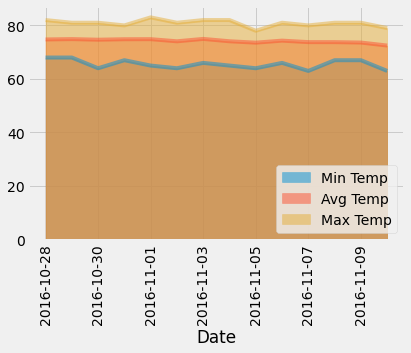

In [190]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area(stacked=False)
plt.xticks(rotation=90)
plt.legend(loc="lower right")
plt.show()